In [2]:
# install packages in libs (as editable)
# !python -m pip install -e ../libs

# What is this notebook for ?

To analyze the results of the test run on owlv2 model
1. Merge the results with input data
2. Build and review confusion matrix
3. Look for few positive and negative results
4. Compare and contrast the predicted vs target

## Load input/target and results

In [3]:
from binsense.lightning.config import Config as TrainConfig
from binsense.lightning.config import coco_train_cfg
from binsense.dataset_util import Dataset as BinsenseDataset
from binsense.dataset_util import DataTag, Yolov8Deserializer

import pandas as pd
import os

def _get_best_bboxes(downloaded_ds: BinsenseDataset) -> pd.DataFrame:
    bbox_df = pd.DataFrame(columns=['bbox_label', 'image_name', 'image_path', 'bbox_idx', 'bbox_area'])
    imgs_data = downloaded_ds.get_images(DataTag.TRAIN)
    for img_data in imgs_data:
        bboxes_data = downloaded_ds.get_bboxes(img_data.name)
        for bbox_idx, bbox_data in enumerate(bboxes_data):
            bbox_df.loc[len(bbox_df)] = [
                bbox_data.label, img_data.name, 
                img_data.path, bbox_idx,
                bbox_data.width*bbox_data.height
            ]
    
    best_bbox_idxs = bbox_df.groupby('bbox_label')['bbox_area'].idxmax()
    best_bbox_df = bbox_df.loc[best_bbox_idxs][['bbox_label', 'image_name', 'image_path', 'bbox_idx']]
    best_bbox_df.reset_index(drop=True, inplace=True)
    del bbox_df
    return best_bbox_df

cfg = coco_train_cfg()
downloaded_ds = Yolov8Deserializer(
        os.path.join(cfg.data_dirpath, 'filtered_dataset'),
        img_extns=['.jpg']).read()
best_bbox_df =_get_best_bboxes(downloaded_ds)

experiment_run = 'testbaseline' # 'testv0' # 'testbaseline' # 'testv0_epoch20'
inputs_fpath = os.path.join(cfg.data_csv_filepath)
inputs_df = pd.read_csv(inputs_fpath)
inputs_df['image_name'] = inputs_df['image_relpath'].str.split('/').str[-1]

train_inputs_df = inputs_df.query('tag == "train"')
test_inputs_df = inputs_df.query('tag == "test"')

results_fpath = os.path.join(cfg.data_dirpath, f'testresults_{experiment_run}.csv')
results_df = pd.read_csv(results_fpath)

combined_df = test_inputs_df.merge(results_df, right_on="input_idx", how="inner", left_index=True)
print(combined_df.shape, inputs_df.shape, results_df.shape)

combined_df = combined_df[['query_label', 'image_relpath', 'count', 'bbox_coords', 'pred_boxes_count', 'pred_boxes_scores', 'pred_boxes_coords']]
combined_df.head()

(176, 10) (828, 6) (176, 4)


,query_label,image_relpath,count,bbox_coords,pred_boxes_count,pred_boxes_scores,pred_boxes_coords
0,bowl,filtered_dataset/test/images/000000402346.jpg,1,NaN,15,0.9999159574508667 0.9996629953384399 0.999626...,0.5068714022636414 0.5047158002853394 0.983839...
1,vase,filtered_dataset/test/images/000000402346.jpg,2,NaN,15,0.9760371446609497 0.9709639549255371 0.922949...,0.5830172896385193 0.5708341002464294 0.606118...
2,car,filtered_dataset/test/images/000000057149.jpg,2,NaN,15,0.9999362230300903 0.9998303651809692 0.999569...,0.4950101375579834 0.48151347041130066 0.97959...
3,train,filtered_dataset/test/images/000000057149.jpg,1,NaN,15,0.9999898672103882 0.9999532699584961 0.999932...,0.4950101375579834 0.48151347041130066 0.97959...
4,bus,filtered_dataset/test/images/000000057149.jpg,1,NaN,15,0.9999929666519165 0.9999831914901733 0.999943...,0.4950101375579834 0.48151347041130066 0.97959...


## Metrics and Confusion matrix 
Our query is if the bin has the required qty. We will look at these metrics.
- exists: (target count > 0 and pred count > 0) or (target count == 0 and pred count == 0)
- matches: target count == pred count

Additionaly to exactly match the query, we can simulate few queries with different count (say query_qty) and compute the below metric.
- meets: pred count > query_qty

In [4]:
from binsense import torch_utils as tutls
from binsense.lightning.metrics import QueryAccuracy

import pandas as pd
import numpy as np

import torch

def format_bbox_coords(bbox_count: int, bbox_coords: str) -> torch.Tensor:
        if bbox_count == 0 or not isinstance(bbox_coords, str):
            return tutls.empty_float_tensor()
        
        coords = torch.as_tensor(list(map(np.float32, bbox_coords.split())))
        return coords.reshape(bbox_count, 4)

def format_bbox_scores(bbox_count: int, bbox_scores: str) -> torch.Tensor:
        if bbox_count == 0 or not isinstance(bbox_scores, str):
            return tutls.empty_float_tensor()
        
        scores = torch.as_tensor(list(map(np.float32, bbox_scores.split())))
        return scores
    
def apply_threshold(df: pd.DataFrame, score_threshold: float = 0.95):
    df['pred_count'] = df['pred_boxes_count']
    for i in df.index:
        scores = format_bbox_scores(df.iloc[i]['pred_boxes_count'], df.iloc[i]['pred_boxes_scores'])
        df.loc[i, 'pred_count'] = len(scores[scores > score_threshold])
    return df

def compute_metrics(df: pd.DataFrame, score_threshold: float = 0.95):
    exists_acc = QueryAccuracy(criteria="exists")
    meets_acc = QueryAccuracy(criteria="meets")
    matches_acc = QueryAccuracy(criteria="matches")
    
    df = apply_threshold(df, score_threshold)
    pred = tutls.to_int_tensor(df["pred_count"])
    tgt  = tutls.to_int_tensor(df["count"])
    
    exists_acc(pred, tgt)
    meets_acc(pred, tgt)
    matches_acc(pred, tgt)
    
    return exists_acc.compute().item(), meets_acc.compute().item(), matches_acc.compute().item()
    

In [5]:
acc_df = pd.DataFrame(columns=['threshold', 'exists', 'meets', 'matches'])
for th in [0.3, 0.35, 0.4, 0.45, 0.5, 0.75, 0.8, 0.9, 0.95, 0.98, 0.998, 0.99998]:
    acc_df.loc[len(acc_df)] = [th, *compute_metrics(combined_df, th)]
acc_df

,threshold,exists,meets,matches
0,0.30000,0.994318,0.994318,0.000000
1,0.35000,0.994318,0.994318,0.000000
2,0.40000,0.994318,0.994318,0.000000
3,0.45000,0.994318,0.994318,0.000000
4,0.50000,0.994318,0.994318,0.000000
5,0.75000,0.988636,0.988636,0.022727
6,0.80000,0.988636,0.988636,0.022727
7,0.90000,0.982955,0.977273,0.022727
8,0.95000,0.977273,0.971591,0.056818
9,0.98000,0.965909,0.937500,0.079545


exists accuracy =  98.86


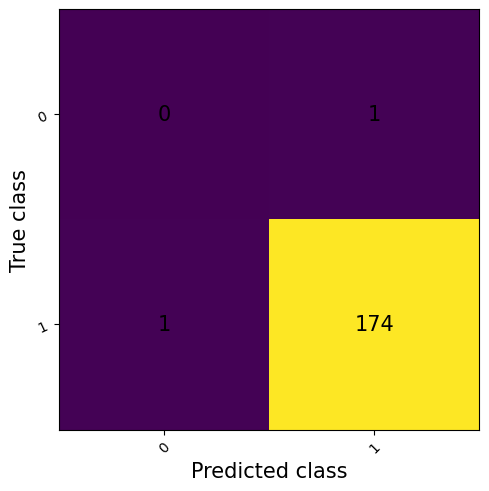

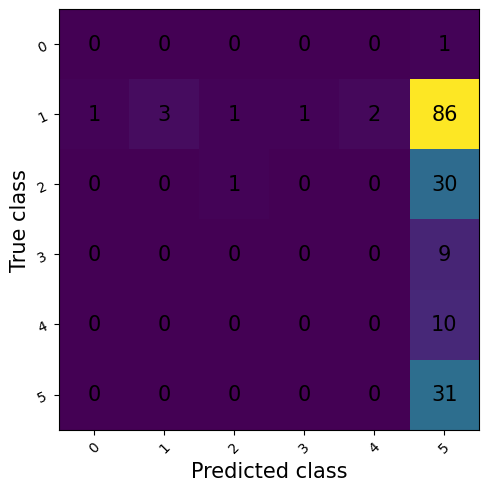

In [6]:
from torchmetrics import ConfusionMatrix
from matplotlib import pyplot as plt
import torch

score_threshold = 0.75
df = apply_threshold(combined_df, score_threshold)

# exists
gt = df["count"].clip(0, 1, axis=0)
pred = df["pred_count"].clip(0, 1, axis=0)
exists_acc = sum(gt == pred) / gt.shape[0]

exists_cmatrix = ConfusionMatrix(task="binary", num_classes=2)
exists_cmatrix(torch.as_tensor(pred.to_numpy()), torch.as_tensor(gt.to_numpy()))
print('exists accuracy = ', round(exists_acc * 100, 2))

exists_cmatrix.plot()
plt.show()

num_classes = 6
gt = df["count"].clip(0, num_classes-1, axis=0)
pred = df["pred_count"].clip(0, num_classes-1, axis=0)
matches_cmatrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)
matches_cmatrix(torch.as_tensor(pred.to_numpy()), torch.as_tensor(gt.to_numpy()))
matches_cmatrix.plot()
plt.show()

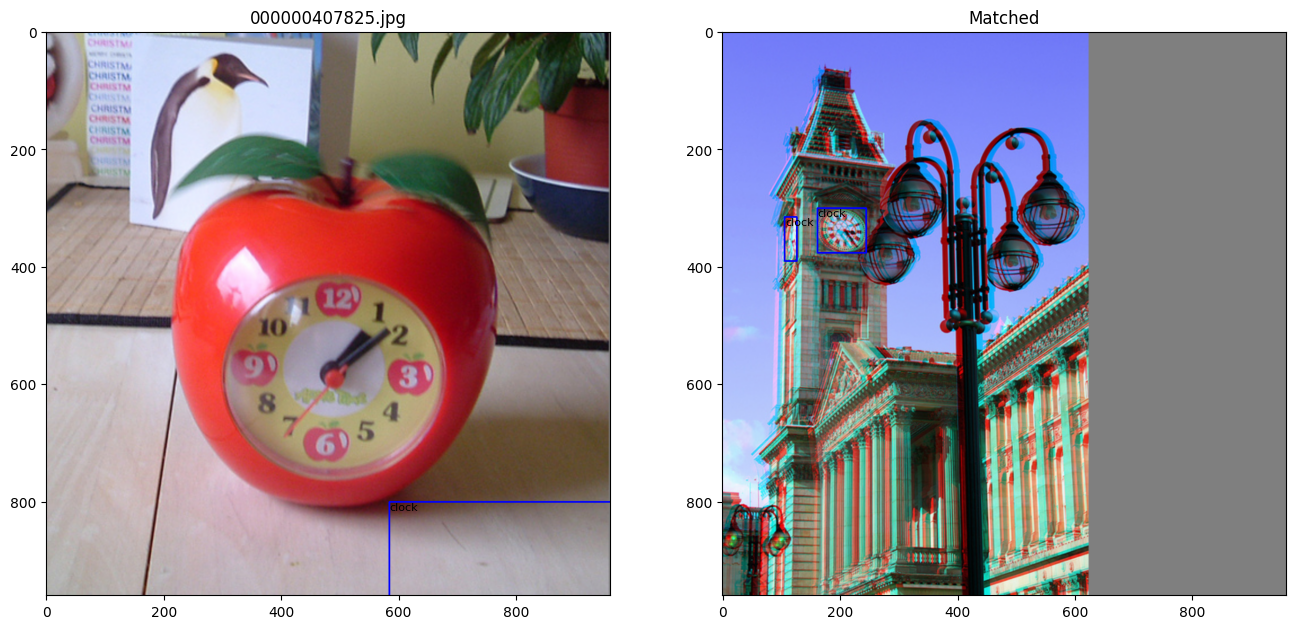

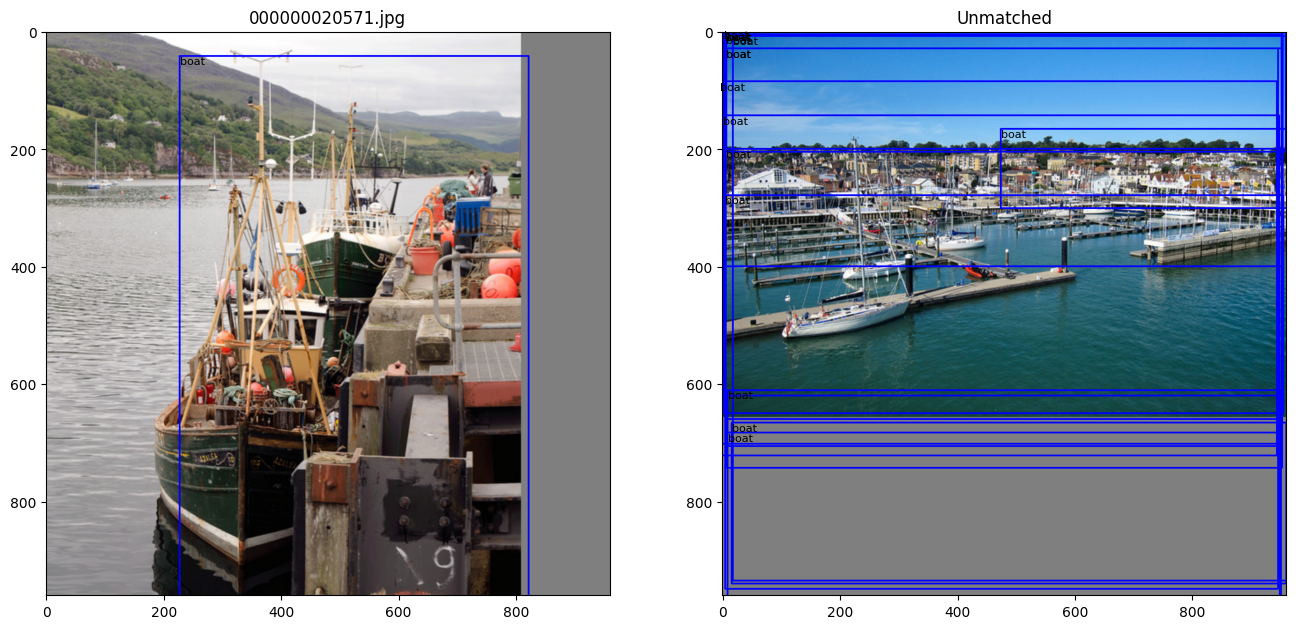

In [34]:
from binsense.img_utils import convert_cxy_xy_and_scale, center_to_corners
from binsense.plot_utils import plot_bboxes
from matplotlib.pyplot import Axes
from binsense.owlv2.processor import Owlv2ImageProcessor
from binsense.owlv2.constants import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD

import numpy as np

import PIL

img_preprocessor = Owlv2ImageProcessor()
def get_preprocessed_image(img_path):
    img_pil = to_pilimage(img_path)
    pixel_values = img_preprocessor.preprocess(img_pil)['pixel_values'][0]
    pixel_values = pixel_values.squeeze().numpy()
    unnormalized_image = (pixel_values * np.array(OPENAI_CLIP_STD)[:, None, None]) + np.array(OPENAI_CLIP_MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    unnormalized_image = PIL.Image.fromarray(unnormalized_image)
    return unnormalized_image


def to_pilimage(relpath):
    return PIL.Image.open(os.path.join(cfg.data_dirpath, relpath))

def to_bboxes(bbox_coords, count, img_size):
    bboxes = []
    ccords = bbox_coords.split()
    for i in range(count):
        bbox = np.array([float(v) for v in ccords[i*4:i*4+4]])
        bboxes.append(bbox)
    
    return convert_cxy_xy_and_scale(np.array(bboxes), img_size)

def to_transformed_bboxes(bbox_coords, count, orig_size):
    bboxes = []
    ccords = bbox_coords.split()
    for i in range(count):
        bbox = np.array([float(v) for v in ccords[i*4:i*4+4]])
        bboxes.append(bbox)
    
    bboxes = np.array(bboxes)
    max_length = max(orig_size[0], orig_size[1])
    bboxes[:,0] = bboxes[:,0] * orig_size[0] / max_length
    bboxes[:,1] = bboxes[:,1] * orig_size[1] / max_length
    return center_to_corners(bboxes)

def draw_train_image(query_label, ax: Axes):
    image_name = best_bbox_df.query(f'bbox_label == "{query_label}"').iloc[0]['image_name']
    trec = train_inputs_df[ (train_inputs_df['query_label'] == query_label) & (train_inputs_df['image_name'] == image_name) & (train_inputs_df['count'] > 0) ].iloc[0]
    
    img_pil = to_pilimage(trec['image_relpath'])
    orig_size = (img_pil.width, img_pil.height)
    img_pil = get_preprocessed_image(trec['image_relpath'])
    bboxes = to_transformed_bboxes(trec['bbox_coords'], 1, orig_size, (img_pil.width, img_pil.height))
    bboxes[:, [0, 2]] = bboxes[:, [0, 2]] * img_pil.width
    bboxes[:, [1, 3]] = bboxes[:, [1, 3]] * img_pil.height
    
    plot_bboxes(
        cv_img=np.array(img_pil),
        bboxes=bboxes,
        labels=[query_label], ax=ax
    )
    ax.set_title(os.path.split(trec['image_relpath'])[1])

def draw_test_image(rec, ax: Axes, show_count=15):
    img_pil = get_preprocessed_image(rec['image_relpath'])
    scores = format_bbox_scores(rec['pred_boxes_count'], rec['pred_boxes_scores'])
    bboxes = to_bboxes(rec['pred_boxes_coords'], rec['pred_boxes_count'], (img_pil.width, img_pil.height))
    bboxes = bboxes[scores > score_threshold]
    labels = [rec['query_label']] * len(bboxes)
    
    cnt = min(show_count, rec['pred_count'])
    if cnt == 0:
        bboxes = []
        labels = []
    
    plot_bboxes(
        cv_img=np.array(img_pil),
        bboxes=bboxes,
        labels=labels, ax=ax
    )
    ax.set_title(os.path.split(rec['image_relpath'])[1])


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
axs = [axs]
fp = df.query(f'pred_count == count').sample(1)
draw_train_image(fp['query_label'].values[0], axs[0][0])
draw_test_image(fp.iloc[0], axs[0][1], show_count=fp.iloc[0]['count'])
axs[0][1].set_title('Matched')
plt.show()


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
axs = [axs]
fp = df.query(f'pred_count != count').sample(1)
draw_train_image(fp['query_label'].values[0], axs[0][0])
draw_test_image(fp.iloc[0], axs[0][1], show_count=fp.iloc[0]['count'])
axs[0][1].set_title('Unmatched')
plt.show()

# tp_1 = combined_df.query('count == 0 & pred_boxes_count > 0').sample(1)
# tp_2 = combined_df.query('count > 0 & pred_boxes_count > 0').sample(1)

# fig, axs = plt.subplots(nrows=4, ncols=2)
# for count in range(1, 5):
#     #tp = combined_df.query(f'count == {count} & pred_boxes_count == count').sample(1)
#     fp = combined_df.query(f'count == {count} & pred_boxes_count != count').sample(1)
#     # draw_train_image(tp['query_label'].values[0], axs[count][0])
#     # draw_test_image(tp.iloc[0], axs[count][1], show_count=0)
#     
#     draw_train_image(fp['query_label'].values[0], axs[count-1][0])
#     draw_test_image(fp.iloc[0], axs[count-1][1], show_count=0)

# plt.show()